In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
from pathlib import Path
import math, random
import nltk
import re
import word_category_counter
import time
import word2vec_extractor
from sklearn import tree, naive_bayes, svm
import matplotlib.pyplot as plt

#W2vecextractor = word2vec_extractor.Word2vecExtractor("GoogleNews-vectors-negative300.bin")

#Get our data
#Label data based on rating
#Extract features
#split between train, dev, and test

#Choose classifier 
#Train classifier (on train data)

#Test classifier (on dev data)


C:\Users\Beth\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
#Get our data

#standard preprocessing
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag
EOJ = 'xeoj'  # end of joke tag

#get jokes:
PATH=Path('data')

files = list(PATH.iterdir())

for fname in files:
    if "eddit" in str(fname):
        reddit_dataset = str(fname)
    if "upid" in str(fname):
        stupid_dataset = str(fname)
reddit_jokes = json.load(open(reddit_dataset))
stupid_jokes = json.load(open(stupid_dataset))

#discard reddit jokes with 0 score:
rated_jokes = [joke for joke in reddit_jokes if joke['score'] > 0]

#regularize to match stupid_jokes:
title_body = [joke['title']+' '+joke['body'] for joke in rated_jokes]

all_jokes = []
for i in range(len(reddit_jokes)):
    r_joke = reddit_jokes[i]
    #|print(r_joke)
    r_joke['rating']=round(math.log(r_joke['score']+random.randrange(1,10))/math.log(10)*5/2, 2)
    if r_joke['rating']>5:
        r_joke['rating']=5
    del r_joke['score'] 
    r_joke['body'] = r_joke['title']+" "+r_joke['body']
    del r_joke['title']
for s_joke in stupid_jokes:
    del s_joke['category']

#combine joke sets:
combined_jokes = reddit_jokes + stupid_jokes

random.Random(42).shuffle(combined_jokes)

In [4]:
#Group into funny and notFunny sets:

funny_joke_list = []
not_funny_joke_list = []
for joke in combined_jokes:
    if joke["rating"] >= 2.5:
        funny_joke_list.append(joke)
    elif joke["rating"] > 0:
        not_funny_joke_list.append(joke)
        
(len(funny_joke_list), len(not_funny_joke_list) )

(91761, 99694)

# Feature Extraction:

In [42]:
# get unigrams and bigrams:
stopwords = nltk.corpus.stopwords.words("english")

liwc_cat_all = ['Total Function Words', 'Total Pronouns', 'Personal Pronouns', 
            'First Person Singular', 'First Person Plural', 'Second Person', 
            'Third Person Singular', 'Third Person Plural', ' Impersonal Pronouns', 
            'Articles', 'Common Verbs', 'Auxiliary Verbs', 'Past Tense', 'Present Tense',  
            'Future Tense', 'Adverbs', 'Prepositions', 'Conjunctions', 'Negations', 'Quantifiers',
            'Number', 'Swear Words', 'Social Processes', 'Family', 'Friends', 'Humans', 
            'Affective Processes', 'Positive Emotion', 'Negative Emotion', 'Anxiety', 'Anger',  
            'Sadness',  'Cognitive Processes', 'Insight', 'Causation', 'Discrepancy', 'Tentative',
            'Certainty', 'Inhibition', 'Inclusive', 'Exclusive', 'Perceptual Processes', 'See', 
            'Hear', 'Feel', 'Biological Processes', 'Body', 'Health', 'Sexual', 'Ingestion', 
            'Relativity', 'Motion', 'Space', 'Time', 'Work', 'Achievement', 'Leisure', 'Home', 
            'Money', 'Religion', 'Death', 'Assent', 'Nonfluencies', 'Fillers', 
            'Total first person', 'Total third person', 'Positive feelings', 'Optimism and energy',
            'Communication', 'Other references to people', 'Up', 'Down', 'Occupation', 'School', 
            'Sports', 'TV', 'Music', 'Metaphysical issues', 'Physical states and functions', 
            'Sleeping', 'Grooming']

liwc_cat_subset = ['Cognitive Processes','Humans', 'Present Tense','Space','Auxiliary Verbs',
                   'Exclusive','Adverbs','Social Processes','Insight','Motion','Quantifiers',
                   'Achievement']

liwc_cat_binned_subset = ['Death','Anxiety','Social Processes']

def normalize(text):
    tokenized_text = []
    tags = []
    for sent in nltk.sent_tokenize(text):
        intermediate = [word for word in nltk.word_tokenize(sent) 
                        if (word not in stopwords) and re.search(r"\w", word)]
        for word, pos in nltk.pos_tag(intermediate):
            tokenized_text.append(word.lower())
            tags.append(pos)
    return tokenized_text, tags

def bin_value(value, cutoff):
    return math.ceil( min( math.floor(value), cutoff ) )

def get_ngrams(tokens):
    unigrams = nltk.FreqDist(tokens)
    bigrams = nltk.FreqDist(nltk.bigrams(tokens))
    
    feature_vector = {}
    for token, freq in unigrams.items():
        feature_vector["UNI_%s" %(token)] = 1#float(freq)/unigrams.N() 
    for (token1, token2), freq in bigrams.items():
        feature_vector["BI_(%s,%s)" %(token1,token2)] = bin_value(float(freq)/bigrams.N() *30, 5)     
    return feature_vector
        #"%s ahhhhh! %s" %("sdflks", "sdff")
    
def get_pos(tags):
    unigrams = nltk.FreqDist(tags)
    bigrams = nltk.FreqDist(nltk.bigrams(tags))
    
    feature_vector = {}
    for token, freq in unigrams.items():
        feature_vector["UNIPOS_%s" %(token)] = bin_value(float(freq)/unigrams.N() *10, 5)
    for (token1, token2), freq in bigrams.items():
        feature_vector["BIPOS_(%s,%s)" %(token1,token2)] = bin_value(float(freq)/bigrams.N() *30, 5)        
    return feature_vector

def get_liwc_features(tokens):
    """
    Adds all possible LIWC derived feature

    :param words:
    :return:
    """
    text = u" ".join(tokens)
    liwc_cat = list(set(liwc_cat_binned_subset + liwc_cat_subset)) #liwc_cat_all

    feature_vectors = {}
    liwc_scores = word_category_counter.score_text(text)

    for cat in liwc_cat:
        if cat in liwc_scores:
            label = cat.lower().replace(" ", "_")
            feature_vectors["liwc_%s" %label] = bin_value(liwc_scores[cat], 10)

    return feature_vectors

def get_word_embeddings(text):
    
    feature_dict = W2vecextractor.get_doc2vec_feature_dict(text)

    return feature_dict

In [43]:
start = time.time()
funny_feature_tuples = []
set_size= 4000 #int(min(len(funny_joke_list), len(not_funny_joke_list))*4/5)
division_size = int(set_size*4/5)

# all_tokens = []
# for joke in funny_joke_list[:division_size]+not_funny_joke_list[:division_size]:
#     tokens, tags = normalize(joke["body"])
#     all_tokens+=tokens
    
# freqDist = nltk.FreqDist(all_tokens)
# frequent_words = []
# for token, freq in freqDist.items():
#     if freq >= 3:
#         frequent_words.append(freq)
# print(len(frequent_words))
# print(len(freqDist.items()))

for joke in funny_joke_list[:set_size]:
    tokens, tags = normalize(joke["body"])
    freq_tokens = [token for token in tokens if token in frequent_words]
    funny_feature_tuples.append(({**get_ngrams(tokens), **get_pos(tags), **get_liwc_features(tokens)},"funny"))
    
unfunny_feature_tuples = []
for joke in not_funny_joke_list[:set_size]:
    tokens, tags = normalize(joke["body"])
    freq_tokens = [token for token in tokens if token in frequent_words]
    unfunny_feature_tuples.append(({**get_ngrams(tokens), **get_pos(tags), **get_liwc_features(tokens)},"unfunny"))
    
time.time() - start

353.945095539093

In [28]:
funny_feature_tuples[200]

({'BIPOS_(DT,NN)': 2,
  'BIPOS_(JJR,VBD)': 2,
  'BIPOS_(NNS,NNS)': 4,
  'BIPOS_(NNS,RB)': 4,
  'BIPOS_(RB,VBD)': 2,
  'BIPOS_(RB,VBP)': 2,
  'BIPOS_(VBD,DT)': 2,
  'BIPOS_(VBD,NNS)': 2,
  'BIPOS_(VBP,NNS)': 2,
  'BIPOS_(VBZ,JJR)': 2,
  'BIPOS_(WP,VBZ)': 2,
  'BI_(a,seatbelt)': 2,
  'BI_(best,jerked)': 2,
  'BI_(breasts,inserts)': 2,
  'BI_(fits,breasts)': 2,
  'BI_(gets,longer)': 2,
  'BI_(hole,works)': 2,
  'BI_(inserts,neatly)': 2,
  'BI_(jerked,a)': 2,
  'BI_(longer,pulled)': 2,
  'BI_(neatly,hole)': 2,
  'BI_(pulled,fits)': 2,
  'BI_(what,gets)': 2,
  'BI_(works,best)': 2,
  'UNIPOS_DT': 0,
  'UNIPOS_JJR': 0,
  'UNIPOS_NN': 0,
  'UNIPOS_NNS': 2,
  'UNIPOS_RB': 1,
  'UNIPOS_VBD': 1,
  'UNIPOS_VBP': 0,
  'UNIPOS_VBZ': 0,
  'UNIPOS_WP': 0,
  'liwc_achievement': 7,
  'liwc_present_tense': 7,
  'liwc_quantifiers': 7},
 'funny')

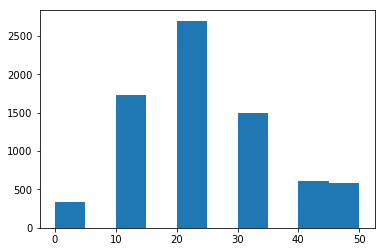

In [23]:
feature_name = "UNIPOS_NN"
tuples = [feature_tuple[0] for feature_tuple 
          in funny_feature_tuples + unfunny_feature_tuples
          if feature_name in feature_tuple[0]]

values = [t[feature_name]*10 for t in tuples]
plt.hist(values);

### Partitioning

In [44]:
division_size = int(set_size*4/5)
train = funny_feature_tuples[:division_size]+unfunny_feature_tuples[:division_size]
dev = funny_feature_tuples[division_size:set_size]+unfunny_feature_tuples[division_size:set_size]

# Training:

In [45]:
# classifier = nltk.classify.NaiveBayesClassifier.train(train)
# classifier.most_informative_features(100)
classifier = nltk.classify.scikitlearn\
           .SklearnClassifier(naive_bayes.BernoulliNB(binarize=False)).train(train)
    
#classifier = nltk.classify.scikitlearn.SklearnClassifier(svm.SVC()).train(train)

In [46]:
accuracy = nltk.classify.accuracy(classifier, dev)
accuracy

0.55625

In [47]:
features_only = []
labels_only = []
for vector, label in dev:
    features_only.append(vector)
    labels_only.append(label)
    

predicted_labels = classifier.classify_many(features_only)

confusion_matrix = nltk.ConfusionMatrix(labels_only, predicted_labels)
print(confusion_matrix)

        |       u |
        |       n |
        |   f   f |
        |   u   u |
        |   n   n |
        |   n   n |
        |   y   y |
--------+---------+
  funny |<407>393 |
unfunny | 317<483>|
--------+---------+
(row = reference; col = test)



# Things to try:

Word embeddings

Binning